# Explainability for Deep Learning Climate Downscaling

This notebook demonstrates how to apply **Explainable AI (XAI)** techniques to deep learning models trained for spatial downscaling from ERA5 to CERRA temperature data over South-East Europe (SEE). We will use the [Quantus](https://github.com/understandable-machine-intelligence-lab/quantus) library to apply and evaluate saliency-based XAI methods.

## 🔍 Goals
- Load trained models and test data
- Generate saliency maps using Quantus
- Compare explanation patterns between DeepESD and U-Net
- Visualize attribution over the spatial domain

In [1]:
import logging

logging.basicConfig(level=logging.INFO)
logging.info("🔁 Starting imports...")

try:
    import os

    logging.info("✅ Imported os")

    import torch

    logging.info("✅ Imported torch")

    import xarray as xr

    logging.info("✅ Imported xarray")

    import numpy as np

    logging.info("✅ Imported numpy")

    import pandas as pd

    logging.info("✅ Imported pandas")

    import matplotlib.pyplot as plt

    logging.info("✅ Imported matplotlib")

    import quantus

    logging.info("✅ Imported quantus")

    from xbatcher import BatchGenerator

    logging.info("✅ Imported xbatcher")

    from torch.utils.data import DataLoader

    logging.info("✅ Imported torch.utils.data")

    from IPython.display import display, Image

    logging.info("✅ Imported IPython.display")

    import cartopy.crs as ccrs

    logging.info("✅ Imported cartopy.crs")

    import cartopy.feature as cfeature

    logging.info("✅ Imported cartopy.feature")

    import warnings

    logging.info("✅ Imported warnings")

    from source.model_deepesd import DeepESD
    from source.model_unet import UNet

    logging.info("✅ Imported local models")

except Exception as e:
    logging.error(f"❌ Import failed: {e}")
    raise e

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"📦 Using device: {DEVICE}")

INFO:root:🔁 Starting imports...
INFO:root:✅ Imported os
INFO:root:✅ Imported torch
INFO:root:✅ Imported xarray
INFO:root:✅ Imported numpy
INFO:root:✅ Imported pandas
INFO:root:✅ Imported matplotlib
/home/pereza/miniconda3/envs/clearclimate-ws4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:✅ Imported quantus
INFO:root:✅ Imported xbatcher
INFO:root:✅ Imported torch.utils.data
INFO:root:✅ Imported IPython.display
INFO:root:✅ Imported cartopy.crs
INFO:root:✅ Imported cartopy.feature
INFO:root:✅ Imported warnings
INFO:root:✅ Imported local models
INFO:root:📦 Using device: cuda


## 📥 Load Test Data and Models

In this section, we load the preprocessed test data from ERA5 (inputs) and CERRA (targets), and load the trained models stored on disk.

In [ ]:
from source.generate_dataloader import load_netcdf_pair

logging.info("Generating test dataloader...")

# Paths
test_era5 = "../data/test_era5.nc"
input_lats = xr.open_dataset("../data/test_era5.nc")["lat"].values
input_lons = xr.open_dataset("../data/test_era5.nc")["lon"].values

test_cerra = "../data/test_cerra.nc"
output_lats = xr.open_dataset("../data/test_cerra.nc")["lat"].values
output_lons = xr.open_dataset("../data/test_cerra.nc")["lon"].values

test_dataloader = load_netcdf_pair(test_era5, test_cerra, batch_size=1)
input_sample, target_sample = test_dataloader.dataset[0]
logging.info("Test dataloader created successfully")
logging.info(f"Loaded one test sample with shape: {input_sample.shape}")

INFO:root:Generating test dataloader...


## 🔧 Load Trained DeepESD and U-Net Models

Now we initialize both architectures and load their pre-trained weights. These models were trained for temperature downscaling in the WS4 training notebook.


In [3]:
# Paths to trained models
model_path_deepesd = "../models/model_deepesd.pt"
model_path_unet = "../models/model_unet.pt"

# Infer shapes from test data
input_shape = input_sample.shape[-2:]
output_shape = target_sample.shape[-2:]

logging.info("🔧 Loading DeepESD model...")
deepesd_model = DeepESD(input_shape, output_shape, 1, 1)
deepesd_model.load_state_dict(torch.load(model_path_deepesd, map_location=DEVICE))
deepesd_model.to(DEVICE).eval()
logging.info("✅ DeepESD loaded.")

logging.info("🔧 Loading U-Net model...")
unet_model = UNet(input_shape, output_shape, 1, 1)
unet_model.load_state_dict(torch.load(model_path_unet, map_location=DEVICE))
unet_model.to(DEVICE).eval()
logging.info("✅ U-Net loaded.")

INFO:root:🔧 Loading DeepESD model...
INFO:root:✅ DeepESD loaded.
INFO:root:🔧 Loading U-Net model...
INFO:root:✅ U-Net loaded.


## Load or Generate Explanations

In order to evaluate explainability techniques with Quantus, we need a batch of **inputs**, **targets**, and corresponding **attributions (explanations)**.

There are two options:

- 🔁 **Option A: Use pre-computed attributions**, e.g., from Captum
- 🧠 **Option B: Use a callable explanation function**, such as `quantus.explain()` or a custom function

In this example, we use **Captum** to compute both **Saliency** and **Integrated Gradients** attributions for a single input batch from our test dataset.


In [4]:
# Load predictions and target data
deepesd_ds = xr.open_dataset("../data/test_deepesd.nc")
unet_ds = xr.open_dataset("../data/test_unet.nc")
target_ds = xr.open_dataset("../data/test_cerra.nc")

# Load data
deepesd_np = xr.open_dataset("../data/test_deepesd.nc")[
    "t2m"
].values  # (time, lat, lon)
unet_np = xr.open_dataset("../data/test_unet.nc")["t2m"].values
target_np = xr.open_dataset("../data/test_cerra.nc")["t2m"].values

# Ensure all arrays have shape (time, lat, lon)
if target_np.shape != deepesd_np.shape:
    target_np = np.transpose(target_np, (2, 0, 1))

# Compute RMSE for each pixel (lat, lon)
rmse_deepesd = np.sqrt(np.mean((deepesd_np - target_np) ** 2, axis=0))
rmse_unet = np.sqrt(np.mean((unet_np - target_np) ** 2, axis=0))


def select_diverse_high_error_pixels(error_map, num_pixels=5, min_distance=10):
    flat_indices = np.argsort(error_map.ravel())[::-1]
    lat_lon_indices = np.array(np.unravel_index(flat_indices, error_map.shape)).T

    selected = []
    for lat_idx, lon_idx in lat_lon_indices:
        if all(
            np.linalg.norm(np.array([lat_idx, lon_idx]) - np.array(p)) >= min_distance
            for p in selected
        ):
            selected.append([lat_idx, lon_idx])
        if len(selected) == num_pixels:
            break

    return selected


# Apply to each RMSE map
coords_deepesd = select_diverse_high_error_pixels(
    rmse_deepesd, num_pixels=5, min_distance=10
)
coords_unet = select_diverse_high_error_pixels(rmse_unet, num_pixels=5, min_distance=10)


def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()


def build_pixel_df(model_name, coords, rmse_map):
    output_lat_idx = [lat for lat, lon in coords]
    output_lon_idx = [lon for lat, lon in coords]
    output_lat_val = [output_lats[lat] for lat in output_lat_idx]
    output_lon_val = [output_lons[lon] for lon in output_lon_idx]
    input_lat_idx = [find_nearest_index(input_lats, val) for val in output_lat_val]
    input_lon_idx = [find_nearest_index(input_lons, val) for val in output_lon_val]
    rmse_vals = [rmse_map[lat, lon] for lat, lon in coords]

    return pd.DataFrame(
        {
            "Model": [model_name] * len(coords),
            "RMSE": rmse_vals,
            "output_lat_idx": output_lat_idx,
            "output_lon_idx": output_lon_idx,
            "output_lat_value": output_lat_val,
            "output_lon_value": output_lon_val,
            "input_lat_idx": input_lat_idx,
            "input_lon_idx": input_lon_idx,
        }
    )


# Build separate DataFrames and concatenate
df_deepesd = build_pixel_df("DeepESD", coords_deepesd, rmse_deepesd)
df_unet = build_pixel_df("UNet", coords_unet, rmse_unet)
df = pd.concat([df_deepesd, df_unet], ignore_index=True)

display(df)

,Model,RMSE,output_lat_idx,output_lon_idx,output_lat_value,output_lon_value,input_lat_idx,input_lon_idx
0,DeepESD,1.966037,40,134,43.04,23.84,24,43
1,DeepESD,1.956723,27,66,42.39,20.44,22,30
2,DeepESD,1.915246,37,151,42.89,24.69,24,47
3,DeepESD,1.878949,35,20,42.79,18.14,23,21
4,DeepESD,1.835484,28,137,42.44,23.99,22,44
5,UNet,3.389820,13,127,41.69,23.49,19,42
6,UNet,3.361221,15,68,41.79,20.54,19,30
7,UNet,3.342817,6,115,41.34,22.89,17,40
8,UNet,3.326617,23,122,42.19,23.24,21,41
9,UNet,3.022889,0,98,41.04,22.04,16,36


In [5]:
from captum.attr import Saliency, IntegratedGradients
import torch
import numpy as np
import logging

# Ensure models are in eval mode
deepesd_model.eval()
unet_model.eval()

# Get one batch
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

# Extract input-side pixel indices from df
deepesd_pixels = df[df["Model"] == "DeepESD"][
    ["output_lat_idx", "output_lon_idx"]
].values
unet_pixels = df[df["Model"] == "UNet"][["output_lat_idx", "output_lon_idx"]].values

# Get spatial dimensions from input batch
_, _, H, W = x_batch.shape


def compute_attributions(model, x, lat_idx, lon_idx):
    x = x.requires_grad_()
    lat_idx = min(lat_idx, H - 1)
    lon_idx = min(lon_idx, W - 1)

    def forward_func(input_tensor):
        output = model(input_tensor)
        return output[:, 0, lat_idx, lon_idx]  # shape (B,)

    model.zero_grad()
    saliency = Saliency(forward_func).attribute(x, abs=True)
    intgrad = IntegratedGradients(forward_func).attribute(
        x, baselines=torch.zeros_like(x)
    )

    return saliency.detach().cpu().numpy(), intgrad.detach().cpu().numpy()


# Store results
attributions = {
    "DeepESD": {"saliency": [], "ig": []},
    "UNet": {"saliency": [], "ig": []},
}

# DeepESD
logging.info("🔍 Generating attributions for DeepESD...")
for lat_idx, lon_idx in deepesd_pixels:
    sal, ig = compute_attributions(deepesd_model, x_batch, lat_idx, lon_idx)
    attributions["DeepESD"]["saliency"].append(sal)
    attributions["DeepESD"]["ig"].append(ig)

# UNet
logging.info("🔍 Generating attributions for UNet...")
for lat_idx, lon_idx in unet_pixels:
    sal, ig = compute_attributions(unet_model, x_batch, lat_idx, lon_idx)
    attributions["UNet"]["saliency"].append(sal)
    attributions["UNet"]["ig"].append(ig)

logging.info("✅ All saliency and IG maps computed.")

INFO:root:🔍 Generating attributions for DeepESD...
INFO:root:🔍 Generating attributions for UNet...
INFO:root:✅ All saliency and IG maps computed.


In [6]:
print("DeepESD saliency:", len(attributions["DeepESD"]["saliency"]))
print("UNet saliency:", len(attributions["UNet"]["saliency"]))
print("DeepESD IG:", len(attributions["DeepESD"]["ig"]))
print("UNet IG:", len(attributions["UNet"]["ig"]))

DeepESD saliency: 5
UNet saliency: 5
DeepESD IG: 5
UNet IG: 5


In [10]:
from source.plot_explanation_maps import plot_explanation_map

In [11]:
from IPython.display import Markdown, display

with open("../source/plot_explanation_maps.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))

```python
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np


def plot_explanation_map(
    attr,
    title,
    input_lats=None,
    input_lons=None,
    pixel_coords=None,
    cmap="Oranges",
    filename=None,
):
    # Convert numpy to xarray.DataArray
    data = attr[0, 0, :, :]
    da = xr.DataArray(
        data,
        dims=("lat", "lon"),
        coords={"lat": input_lats, "lon": input_lons},
        name="attribution",
    )

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot attribution
    im = da.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        add_colorbar=True,
        cbar_kwargs={"orientation": "horizontal", "label": "Attribution Value"},
    )

    ax.coastlines(resolution="10m", linestyle="-", linewidths=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.5)

    # Optional pixel highlight
    if pixel_coords:
        lat_idx, lon_idx = pixel_coords
        lat_val = input_lats[lat_idx]
        lon_val = input_lons[lon_idx]
        ax.plot(
            lon_val,
            lat_val,
            marker="o",
            color="black",
            markersize=6,
            transform=ccrs.PlateCarree(),
        )

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return filename

```

NameError: name 'suptitle' is not defined

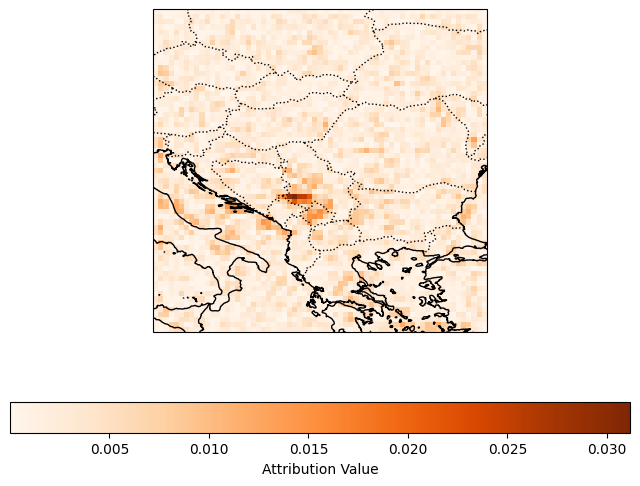

In [12]:
# Generate and save explanation figures
os.makedirs("../outputs/figures/explainability", exist_ok=True)

for i in range(5):
    output_lat_idx, output_lon_idx = deepesd_pixels[i]
    input_coords = df[df["output_lat_idx"] == output_lat_idx][
        df["output_lon_idx"] == output_lon_idx
    ][["input_lat_idx", "input_lon_idx"]].values[0]
    input_lat_idx, input_lon_idx = input_coords

    output_path = plot_explanation_map(
        attributions["DeepESD"]["saliency"][i],
        title="DeepESD - Saliency",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/deepesd_saliency_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))

    output_path = plot_explanation_map(
        attributions["DeepESD"]["ig"][i],
        title="DeepESD - IntegratedGradients",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/deepesd_ig_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )

for i in range(5):
    output_lat_idx, output_lon_idx = unet_pixels[i]
    input_coords = df[df["output_lat_idx"] == output_lat_idx][
        df["output_lon_idx"] == output_lon_idx
    ][["input_lat_idx", "input_lon_idx"]].values[0]
    input_lat_idx, input_lon_idx = input_coords

    output_path = plot_explanation_map(
        attributions["UNet"]["saliency"][i],
        title="UNet - Saliency",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/unet_saliency_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))

    output_path = plot_explanation_map(
        attributions["UNet"]["ig"][i],
        title="UNet - IntegratedGradients",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/unet_ig_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )